Importing Libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import math
plt.rcParams['figure.dpi'] = 1000 # Increase image resolution
plt.rcParams['savefig.dpi'] = 1000 # Increase image resolution
from scipy import optimize
from scipy.optimize import Bounds

Importing, Visualising and Editing Battery Dataframe

In [2]:
df = pd.read_csv('RW3together.csv') # Import Battery Dataset (RW3/RW4/RW5/RW6 = Battery 1/2/3/4 Respectively)
df.comment = pd.Categorical(df.comment) # Conversion to categorical variable

In [3]:
time1 = np.zeros(len(df)) # New time variable to perform dt calculations
regime = np.zeros(len(df)) # Note the starting and ending point of pulsed discharge regime (Starting = 1 and Ending = -1)
time1[0] = df.time[0] # Initialising first value
# Section 5.2 - Noting Starting and Ending Index's
for i in range(1,len(df)):
    time1[i] = df.time[i-1]
    if (df.comment[i-1] == "reference discharge") & (df.comment[i]=="pulsed load (rest)"):
        regime[i] = 1
    elif (df.comment[i-1] == "rest post reference discharge") & (df.comment[i]=="pulsed load (rest)"):
        regime[i] = 1
    elif (df.comment[i-1] == "pulsed load (discharge)") & (df.comment[i]=="charge (after random walk discharge)"):
                  regime[i-1] = -1
    elif (df.comment[i-1] == "pulsed load (discharge)") & (df.comment[i]=="rest post pulsed load"):
                  regime[i-1] = -1
#Creating a new dataframe (Section 3.3.1)
dt = df.time - time1 # Subtracting the shifted gives the time difference (dt) between every datapoint 
df['dt'] = dt # Forming the new column
df1 = df[['comment','voltage','current','temperature','relativeTime','time','dt']] # Reordering the columns
dq = dt*df1["current"] # Forming a new variable with the charge difference (dq) between every datapoint
df1['dq'] = dq # Forming a new column ...
df1["regime"] = regime #Forming a regime column with values -1,0,1

/var/folders/gj/vbyyhc_x1z199k97d4xd9gy40000gn/T/ipykernel_5588/527145117.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dq'] = dq # Forming a new column ...


In [4]:
starting = np.array(df1[df1.regime == 1].index) #Note the starting index of the pulsed discharge regime
ending = np.array(df1[df1.regime == -1].index) #Note the ending index of the pulsed discharge regime
Qrun = np.zeros(len(starting)) #Variable to store optimised "capacity" values over multiple runs (Repetitions) of this regime
R0run = np.zeros(len(starting)) #Variable to store optimised "Resistance" values over multiple runs (Repetitions) of this regime
# Initial Guess value
Qrun[0] = 13200
R0run[0] = 0.085
# Calculating Amperes Discharged until end of ith repetition of the regime 
Amph = np.zeros(len(starting))
for i in range(len(starting)):
    Amph[i] = (sum((df1.dq[:ending[i]])[df1.current >0]))/3600 # eq 5.1

Modelling:

In [ ]:
# Section 5.2 - Outer loop to go regime-wise (Perform one run) for optimisation
for i in range (len(starting)):
    # Choosing ith regime's start and end point
    start = starting[i]
    end = ending[i]
    # Constant Parameters in the Model:
    # Table 3.1
    Ap0 = -33642.23 # (J/mol)
    Ap1 = 0.11 # (J/mol)
    Ap2 = 23506.89 # (J/mol)
    Ap3 = -74679.26 # (J/mol)
    Ap4 = 14359.34 # (J/mol)
    Ap5 = 307849.79 # (J/mol)
    Ap6 = 85053.13 # (J/mol)
    Ap7 = -1075148.06 # (J/mol)
    Ap8 = 2173.62 # (J/mol)
    Ap9 = 991586.68 # (J/mol)
    Ap10 = 283423.47 # (J/mol)
    Ap11 = -163020.34 # (J/mol)
    Ap12 = -470297.35 # (J/mol)
    Ap = [Ap0, Ap1, Ap2, Ap3, Ap4, Ap5, Ap6, Ap7, Ap8, Ap9, Ap10, Ap11, Ap12] # Forming vector with the simplex coefficients
    An0 = 86.19 # (J/mol)
    U0p = 4.03 # (V)
    U0n = 0.01 # (V)
    
    # Table 3.2
    R = 8.314 # (J/mol/K)
    T = 292 # (K)
    F = 96487 # (C/mol)
    n = 1 # (Dimensionless)
    D = 7*(10**6) # (mol s/C/m^3)
    tau0 = 10 # (s)
    taup = 90 # (s)
    taun = 90 # (s)
    alpha = 0.5 # (Dimensionless)
    R0 = 0.085 # (ohm)
    QMAX = 13200 # (C)
    Sp = 2*(10**-4) # (m^2)
    Sn = 2*(10**-4) # (m^2)
    kp = 2*(10**4) # (A/m^2)
    kn = 2*(10**4) # (A/m^2)
    vsp = 2*(10**-6) # (m^3)
    vsn = 2*(10**-6) # (m^3)
    vbp = 2*(10**-5) # (m^3)
    vbn = 2*(10**-5) # (m^3)
    vn = vsn + vbn # (m^3) (eq 3.9)
    vp = vsp + vbp # (m^3) (eq 3.9)
    act_len = (end-start+1) # (eq 3.41) Length of the total number of datapoints in the ith pulsed discharge regime
    
    # Section 4.2 - Function used for giving output as MSE (wrt Voltage) for Different Capacity and Internal Resistance values.
    def Model(opt):
        #opt is a 2D Vector taking in the Capacity and Internal Resistance as an input
        try:
            #Try introduced to direct the solver towards convergence (check at the bottom)
            QMAX_s = opt[0]
            R0_s = opt[1]
            # Intialisation (Section 3.3.4)
            x_t = np.zeros(act_len)
            xn_t = np.zeros(act_len)
            xp_t = np.zeros(act_len)
            xsp_t = np.zeros(act_len)
            xsn_t = np.zeros(act_len)
            xbp_t = np.zeros(act_len)
            xbn_t = np.zeros(act_len)
            qsp_t = np.zeros(act_len)
            qbp_t = np.zeros(act_len)
            qbn_t = np.zeros(act_len)
            qsn_t = np.zeros(act_len)
            qn_t = np.zeros(act_len)
            qp_t = np.zeros(act_len)
            V0_t = np.zeros(act_len)
            Vetap_t = np.zeros(act_len)
            Vetan_t = np.zeros(act_len)
            Jp0_t = np.zeros(act_len)
            Jn0_t = np.zeros(act_len)
            VUp_t = np.zeros(act_len)
            VUn_t = np.zeros(act_len)
            VUpn_t = np.zeros(act_len)
            VINTn_t = np.zeros(act_len)
            VINTp_t = np.zeros(act_len)
            Vetap_tt = np.zeros(act_len)
            Vetan_tt = np.zeros(act_len)
            V0_tt = np.zeros(act_len)
            V_t = np.zeros(act_len)
            qbsn_tt = np.zeros(act_len)
            qbsp_tt = np.zeros(act_len)
            cbp_t = np.zeros(act_len)
            csp_t = np.zeros(act_len)
            cbn_t = np.zeros(act_len)
            csn_t = np.zeros(act_len)
    
            #Coulomb Counting (Section 3.3.4)
            iapp = np.array(df1.current[start:end+1])
            for i in range(act_len):
                qn_t[i] = QMAX_s*0.6 - np.sum(dq[start:start+i]) # (eq 3.42) At, 100% SOC, Charge in the negative terminal (qn) is 0.6 times the total capacity (0.6*QMAX). Thus, qp = 0.4*QMAX
    
            #Surface/Bulk (Positive/Negative) Distributed Charge Calculations (Section 3.2.2/3.3.4)
            #Initialisation:
            qp_t[0] = QMAX_s-qn_t[0] # eq 3.4
            #Initially cs,i = cb,i
            qbp_t[0] = (10/11)*qp_t[0] # eq 3.7/3.8
            qsp_t[0] = (1/11)*qp_t[0] # eq 3.7/3.8
            qsn_t[0] = (1/11)*qn_t[0] # eq 3.7/3.8
            qbn_t[0] = (10/11)*qn_t[0] # eq 3.7/3.8
           
            for i in range(1,act_len):
                # Euler Method with timesteps = Change in dataset's time recording (Since, it's a relatively small scale effect)
                qsp_t[i] = qsp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(iapp[i-1] + (1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.13
                qbp_t[i] = qbp_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbp_t[i-1]/vbp - qsp_t[i-1]/vsp)) # eq 3.14
                qbn_t[i] = qbn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-(1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.15
                qsn_t[i] = qsn_t[i-1] +(df1.time[start+i] - df1.time[start+i-1])*(-iapp[i-1] + (1/D)*(qbn_t[i-1]/vbn - qsn_t[i-1]/vsn)) # eq 3.16
            qp_t=qsp_t+qbp_t # eq 3.10
            qn_t=qsn_t+qbn_t # eq 3.10
            xsn_t = (qsn_t)/((QMAX_s*vsn)/(vn)) # eq 3.18/3.19
            xbn_t = (qbn_t)/((QMAX_s*vbn)/(vn)) # eq 3.18/3.19
            xsp_t = (qsp_t)/((QMAX_s*vsp)/(vp)) # eq 3.18/3.19
            xbp_t = (qbp_t)/((QMAX_s*vbp)/(vp)) # eq 3.18/3.19
            xp_t = (qp_t)/(QMAX_s) # eq 3.4
            xn_t = (qn_t)/(QMAX_s) # eq 3.4  

            #V0,VINT and VU negative/postive electrode calculations - TimeSeries (Section 3.2.2/3.2.3/3.3.4)
            for i in range (act_len):
                VINTsum = np.zeros(13)
                # eq 3.6
                for k in range (len(VINTsum)):
                    VINTsum[k] = (1/(n*F))*(Ap[k])*((((2*xsp_t[i])-1)**(k+1))-(2*xsp_t[i]*k*(1-xsp_t[i])*(((2*xsp_t[i])-1)**(k-1))))
                VINTn_t[i] = (1/(n*F))*(An0)*(2*xsn_t[i]-1) # eq 3.6
                VINTp_t[i] = np.sum(VINTsum) # eq 3.6
                VUp_t[i] = U0p + ((R*T)/(n*F))*(math.log((1-xsp_t[i])/xsp_t[i])) + VINTp_t[i] # eq 3.17
                VUn_t[i] = U0n + ((R*T)/(n*F))*(math.log((1-xsn_t[i])/xsn_t[i])) + VINTn_t[i] # eq 3.17
                V0_t[i] = iapp[i]*R0_s # eq 3.22
    
            #Veta_p/n calculations - TimeSeries (Section 3.2.4/3.3.4)
            for i in range (act_len):
                Jp0_t[i] = kp*((1-xsp_t[i])**0.5)*((xsp_t[i])**0.5) # eq 3.25
                Jn0_t[i] = kn*((1-xsn_t[i])**0.5)*((xsn_t[i])**0.5) # eq 3.25
                Vetap_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sp)/(2*Jp0_t[i]))) # eq 3.23
                Vetan_t[i] = ((R*T)/(F*0.5))*(np.arcsinh((iapp[i]/Sn)/(2*Jn0_t[i]))) # eq 3.23
    
            #Transient Calculations - Euler Method - Timeseries (Section 3.2.6/3.3.4)
            V0_tt[0] = V0_t[0] # eq 3.31
            Vetap_tt[0] = Vetap_t[0] # eq 3.32
            Vetan_tt[0] = Vetan_t[0] # eq 3.33
            for i in range (1,act_len):
                # Euler Method with timesteps = Change in dataset's time recording (Since, it's a relatively small scale effect)
                V0_tt[i] = V0_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/tau0)*(V0_t[i-1]-V0_tt[i-1])) # eq 3.31
                Vetap_tt[i] = Vetap_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taup)*(Vetap_t[i-1]-Vetap_tt[i-1])) # eq 3.32
                Vetan_tt[i] = Vetan_tt[i-1] + (((df1.time[start+i] - df1.time[start+i-1])/taun)*(Vetan_t[i-1]-Vetan_tt[i-1])) # eq 3.33
    
            #SOC Calculations (Section 3.2.5/3.3.4)
            SOCn = np.zeros(act_len)
            SOCa = np.zeros(act_len)
            for i in range(act_len):
                SOCn[i] = 100*(qn_t[i]/(0.6*QMAX_s)) # eq 3.26
                SOCa[i] = 100*((qsn_t[i]*vn)/(0.6*QMAX_s*vsn)) # eq 3.27/3.28
                
                #Final Predicted Voltages (Section 3.2.6/3.3.4)
                V_t[i] = VUp_t[i]- VUn_t[i] - V0_tt[i] - Vetap_tt[i] - Vetan_tt[i] # eq 3.30
                
                # Section 4.3 - Clipping at 3.2V (As in the experiment, the cell operates only b/w 4.2 V & 3.2 V)
                if V_t[i] <3.2:
                    V_t[i] = 3.2
            #Error Calculations
            MAE = (np.sum(abs(V_t - np.array(df1.voltage[start:end+1]))))/(act_len)
            MSE = (np.sum(np.multiply((V_t-np.array(df1.voltage[start:end+1])),(V_t-np.array(df1.voltage[start:end+1]))))/(act_len))
            #Choose MAE/MSE Accordingly by changing the return (Paper used MSE)
            return (MSE)
        except ValueError:
            #The try-catch used over here returns NAN values helping redirect the search algorithm towards convergence
            #Furthermore, it eliminates the need to define bounds in such a case
            print("NaN Returned")
            return(np.nan)
    
    # Guess the previous regime's Capacity and Resistance values (Aged/Deteriorated Values) for optimisation
    if i <=0:
        res=(optimize.minimize(Model,[Qrun[i],R0run[i]],method='Nelder-Mead'))
    else:
        res=(optimize.minimize(Model,[Qrun[i-1],R0run[i-1]],method='Nelder-Mead'))
    Qrun[i] = res.x[0] # Save the optimised Capacity values for ith regime
    R0run[i] = res.x[1] # Save the optimised Resistance values for ith regime
    #Recieve Progress
    print(str(i+1)+" - Pulsed Discharge With Optimisation COMPLETED")


In [5]:
#Measured Capacity wrt Values with respect to Ampere-hours discharged
'''Measured_Capacity = np.zeros(len(starting))
for i in range (len(starting)):
    Measured_Capacity[i] = sum(df1.dq[starting[i]:ending[i]])
plt.figure(figsize=(10, 5))
plt.scatter(Amph1,Measured_Capacity1/3600,label='Battery-1',s=20, marker = "o", color = "blue")
plt.plot(Amph1,Measured_Capacity1/3600,linewidth=0.75,color = "blue")
plt.scatter(Amph2,Measured_Capacity2/3600,label='Battery-2',s=20, marker = "D" , color = "green")
plt.plot(Amph2,Measured_Capacity2/3600,linewidth=0.75, color = "green")
plt.scatter(Amph3,Measured_Capacity3/3600,label='Battery-3',s=20, marker = "s" , color = "red")
plt.plot(Amph3,Measured_Capacity3/3600,linewidth=0.75, color = "red")
plt.ylabel('Measured Capacity (Amph)')
plt.xlabel('Ampere Hours Discharged (Ah)')
plt.title('Measured Capacity Loss with usage')
plt.legend(loc="upper right", prop={'size': 10})
plt.show()'''

'Measured_Capacity = np.zeros(len(starting))\nfor i in range (len(starting)):\n    Measured_Capacity[i] = sum(df1.dq[starting[i]:ending[i]])\nplt.figure(figsize=(10, 5))\nplt.scatter(Amph1,Measured_Capacity1/3600,label=\'Battery-1\',s=20, marker = "o", color = "blue")\nplt.plot(Amph1,Measured_Capacity1/3600,linewidth=0.75,color = "blue")\nplt.scatter(Amph2,Measured_Capacity2/3600,label=\'Battery-2\',s=20, marker = "D" , color = "green")\nplt.plot(Amph2,Measured_Capacity2/3600,linewidth=0.75, color = "green")\nplt.scatter(Amph3,Measured_Capacity3/3600,label=\'Battery-3\',s=20, marker = "s" , color = "red")\nplt.plot(Amph3,Measured_Capacity3/3600,linewidth=0.75, color = "red")\nplt.ylabel(\'Measured Capacity (Amph)\')\nplt.xlabel(\'Ampere Hours Discharged (Ah)\')\nplt.title(\'Measured Capacity Loss with usage\')\nplt.legend(loc="upper right", prop={\'size\': 10})\nplt.show()'

Saved Values:

In [6]:
#Saved Values: 1,2,3,4 Corresponds to Battery 1/2/3/4 accordingly
#Saved values as Qrun1 = Qrun (When using RW3 [Battery-1] dataset), Qrun2 = Qrun (RW4/Battery-2) and so on...
#Battery-1 (RW-3)
Qrun1= np.array([12787.44614246, 12394.14200551, 12060.30025151, 11792.78704359
 ,11351.5311921 , 11061.26720835 ,10900.2729408  ,10747.81993321
 ,10348.69252695 ,10378.24289205 ,10075.72939077, 9869.67916903
  ,9779.00585569 , 9329.11163168 , 9133.48839321 , 8804.07558814
  ,8846.93428636 , 8791.21479583 , 8260.03192221 , 8182.56928206
  ,7818.04961548 , 7256.02139134])
R0run1 = np.array([0.10567153 ,0.10370213, 0.1135248 , 0.12813358 ,0.12685634, 0.13474229
 ,0.14128827, 0.15367314, 0.15030171 ,0.15368631 ,0.15832574 ,0.16565763
 ,0.17357609, 0.17525209, 0.18299886 ,0.19927623 ,0.19237331 ,0.1945904
 ,0.19554823, 0.19205235 ,0.22381611, 0.22277068])
Amph1 = np.array([  8.16562783,  85.76131058, 157.37531727, 225.28466695,
       287.64292734, 347.05612956, 405.68523936, 461.64731351,
       515.49919564, 547.30489134, 599.46029554, 646.93890541,
       691.16989375, 732.88954073, 769.38897574, 803.38366865,
       828.74394944, 856.8203637 , 878.34887891, 902.99851453,
       925.78373852, 942.13128572])
Measured_Capacity1 = np.array([7324.23812, 7079.22276, 6882.24888, 6742.24096, 6483.3308 ,
       6305.32472, 6210.34472, 6126.33564, 5904.32284, 5927.43072,
       5741.3908 , 5609.38468, 5553.37656, 5309.47344, 5188.41664,
       4975.5052 , 5006.5436 , 4977.50436, 4676.56748, 4628.54892,
       4392.57432, 4078.63508])
#Battery-2 (RW-4)
Qrun2 = np.array([12549.06585284, 12117.48138042, 11878.48217361, 11400.88341817
 ,11098.21795974 ,10871.78460778 ,10483.88965114 ,10310.11791873
 ,10287.59594942  ,9974.50430341  ,9824.8481341   ,9740.09870638
 ,10420.31790825  ,8914.80587123  ,8907.56745416  ,8761.86659783
  ,8384.63060658  ,8282.25830889  ,7851.56964632])
R0run2 = np.array([0.11082716 ,0.11238997, 0.12155551, 0.1264819 , 0.13024495, 0.13936443
 ,0.14455252, 0.14691215, 0.14952394 ,0.15332008 ,0.16145797 ,0.16994369
 ,0.1894393  ,0.19156347, 0.18412229 ,0.18977034 ,0.18834612 ,0.18473531
 ,0.2199084 ])
Amph2 =np.array([  8.04082275,  81.37322913, 147.90297281, 211.58079531,
       271.88374847, 328.45652613, 385.64368418, 438.37541244,
       486.0550009 , 535.77509246, 580.24797327, 624.10341396,
       667.03532138, 696.11300951, 722.26898899, 748.73678774,
       761.18676661, 785.86107377, 804.34039643])
Measured_Capacity2 = np.array([7164.21752, 6914.18296, 6783.28564, 6510.207  , 6331.34696,
       6195.28424, 5985.33744, 5882.37412, 5873.32496, 5679.3606 ,
       5584.32228, 5534.3832 , 5195.42124, 5047.41948, 5044.40632,
       4960.44032, 4751.4544 , 4690.47624, 4412.448 ])
#Battery-3 (RW-5)
Qrun3 = np.array([12517.59842139, 12132.63966851 ,11867.60833346, 11397.72840277
 ,11135.40715427 ,10921.11258071 ,10802.33217679 ,10381.37354772
 ,10195.39342547 ,10300.8305888  ,10018.62478843  ,9799.59547818
  ,9459.15420003  ,9028.60404286  ,8913.60648427  ,8823.25316246
  ,8850.5643906   ,8324.3520444   ,8314.5111909   ,7923.12979996
  ,7871.5151781 ])
R0run3 = np.array([0.11226983 ,0.11442197 ,0.12544107 ,0.1299675  ,0.13487123 ,0.14098028
 ,0.14665093 ,0.14842912 ,0.14997336 ,0.15377885 ,0.15649526 ,0.16580274
 ,0.1679878  ,0.18362503 ,0.19236427 ,0.19861172 ,0.18987238 ,0.19153373
 ,0.18750908 ,0.21187249 ,0.21463886])
Amph3 = np.array([  7.97928442,  81.85556825, 151.22634967, 215.55721502,
       278.06817389, 333.31724217, 390.78418826, 443.18373003,
       493.00085047, 503.76077327, 554.81652084, 601.66370323,
       647.82004261, 689.09361384, 720.01236581, 748.15745438,
       777.38025068, 799.32675469, 820.57342778, 842.14095689,
       846.71722808])
Measured_Capacity3 = np.array([7144.26972, 6921.36988, 6774.30896, 6508.42184, 6351.3866 ,
       6222.4658 , 6155.42344, 5924.49604, 5812.51744, 5877.40872,
       5703.49956, 5563.50216, 5387.50632, 5119.47552, 5044.52528,
       4988.51724, 5008.5862 , 4714.62308, 4707.57496, 4456.63596,
       4423.63896])
#Battery-4 (RW-6)
Qrun4 = np.array([12237.15719781,11950.49341918,11769.43675082,11339.73575187
 ,10995.34738185 ,10810.65767828 ,10479.73133674 ,10193.65026969
  ,9920.20461543  ,9742.14616482  ,8995.30620595])
R0run4 = np.array([0.13769055 ,0.12455293, 0.13768249, 0.13298096, 0.14107704 ,0.14949572
 ,0.14546891, 0.14360621 ,0.1562483 , 0.16012802 ,0.16915524])
Amph4= np.array([  7.88526177,  74.94947546, 137.88657219, 200.64133809,
       257.33422397, 311.02164841, 358.46970613, 406.16493225,
       435.81724575, 475.02176307, 504.55112963])
Measured_Capacity4= np.array([6968.38692, 6811.3264 , 6721.35296, 6466.39088, 6256.45856,
       6155.39876, 5969.40384, 5796.49488, 5627.4826 , 5546.4878 ,
       5082.5236])

Plotting:

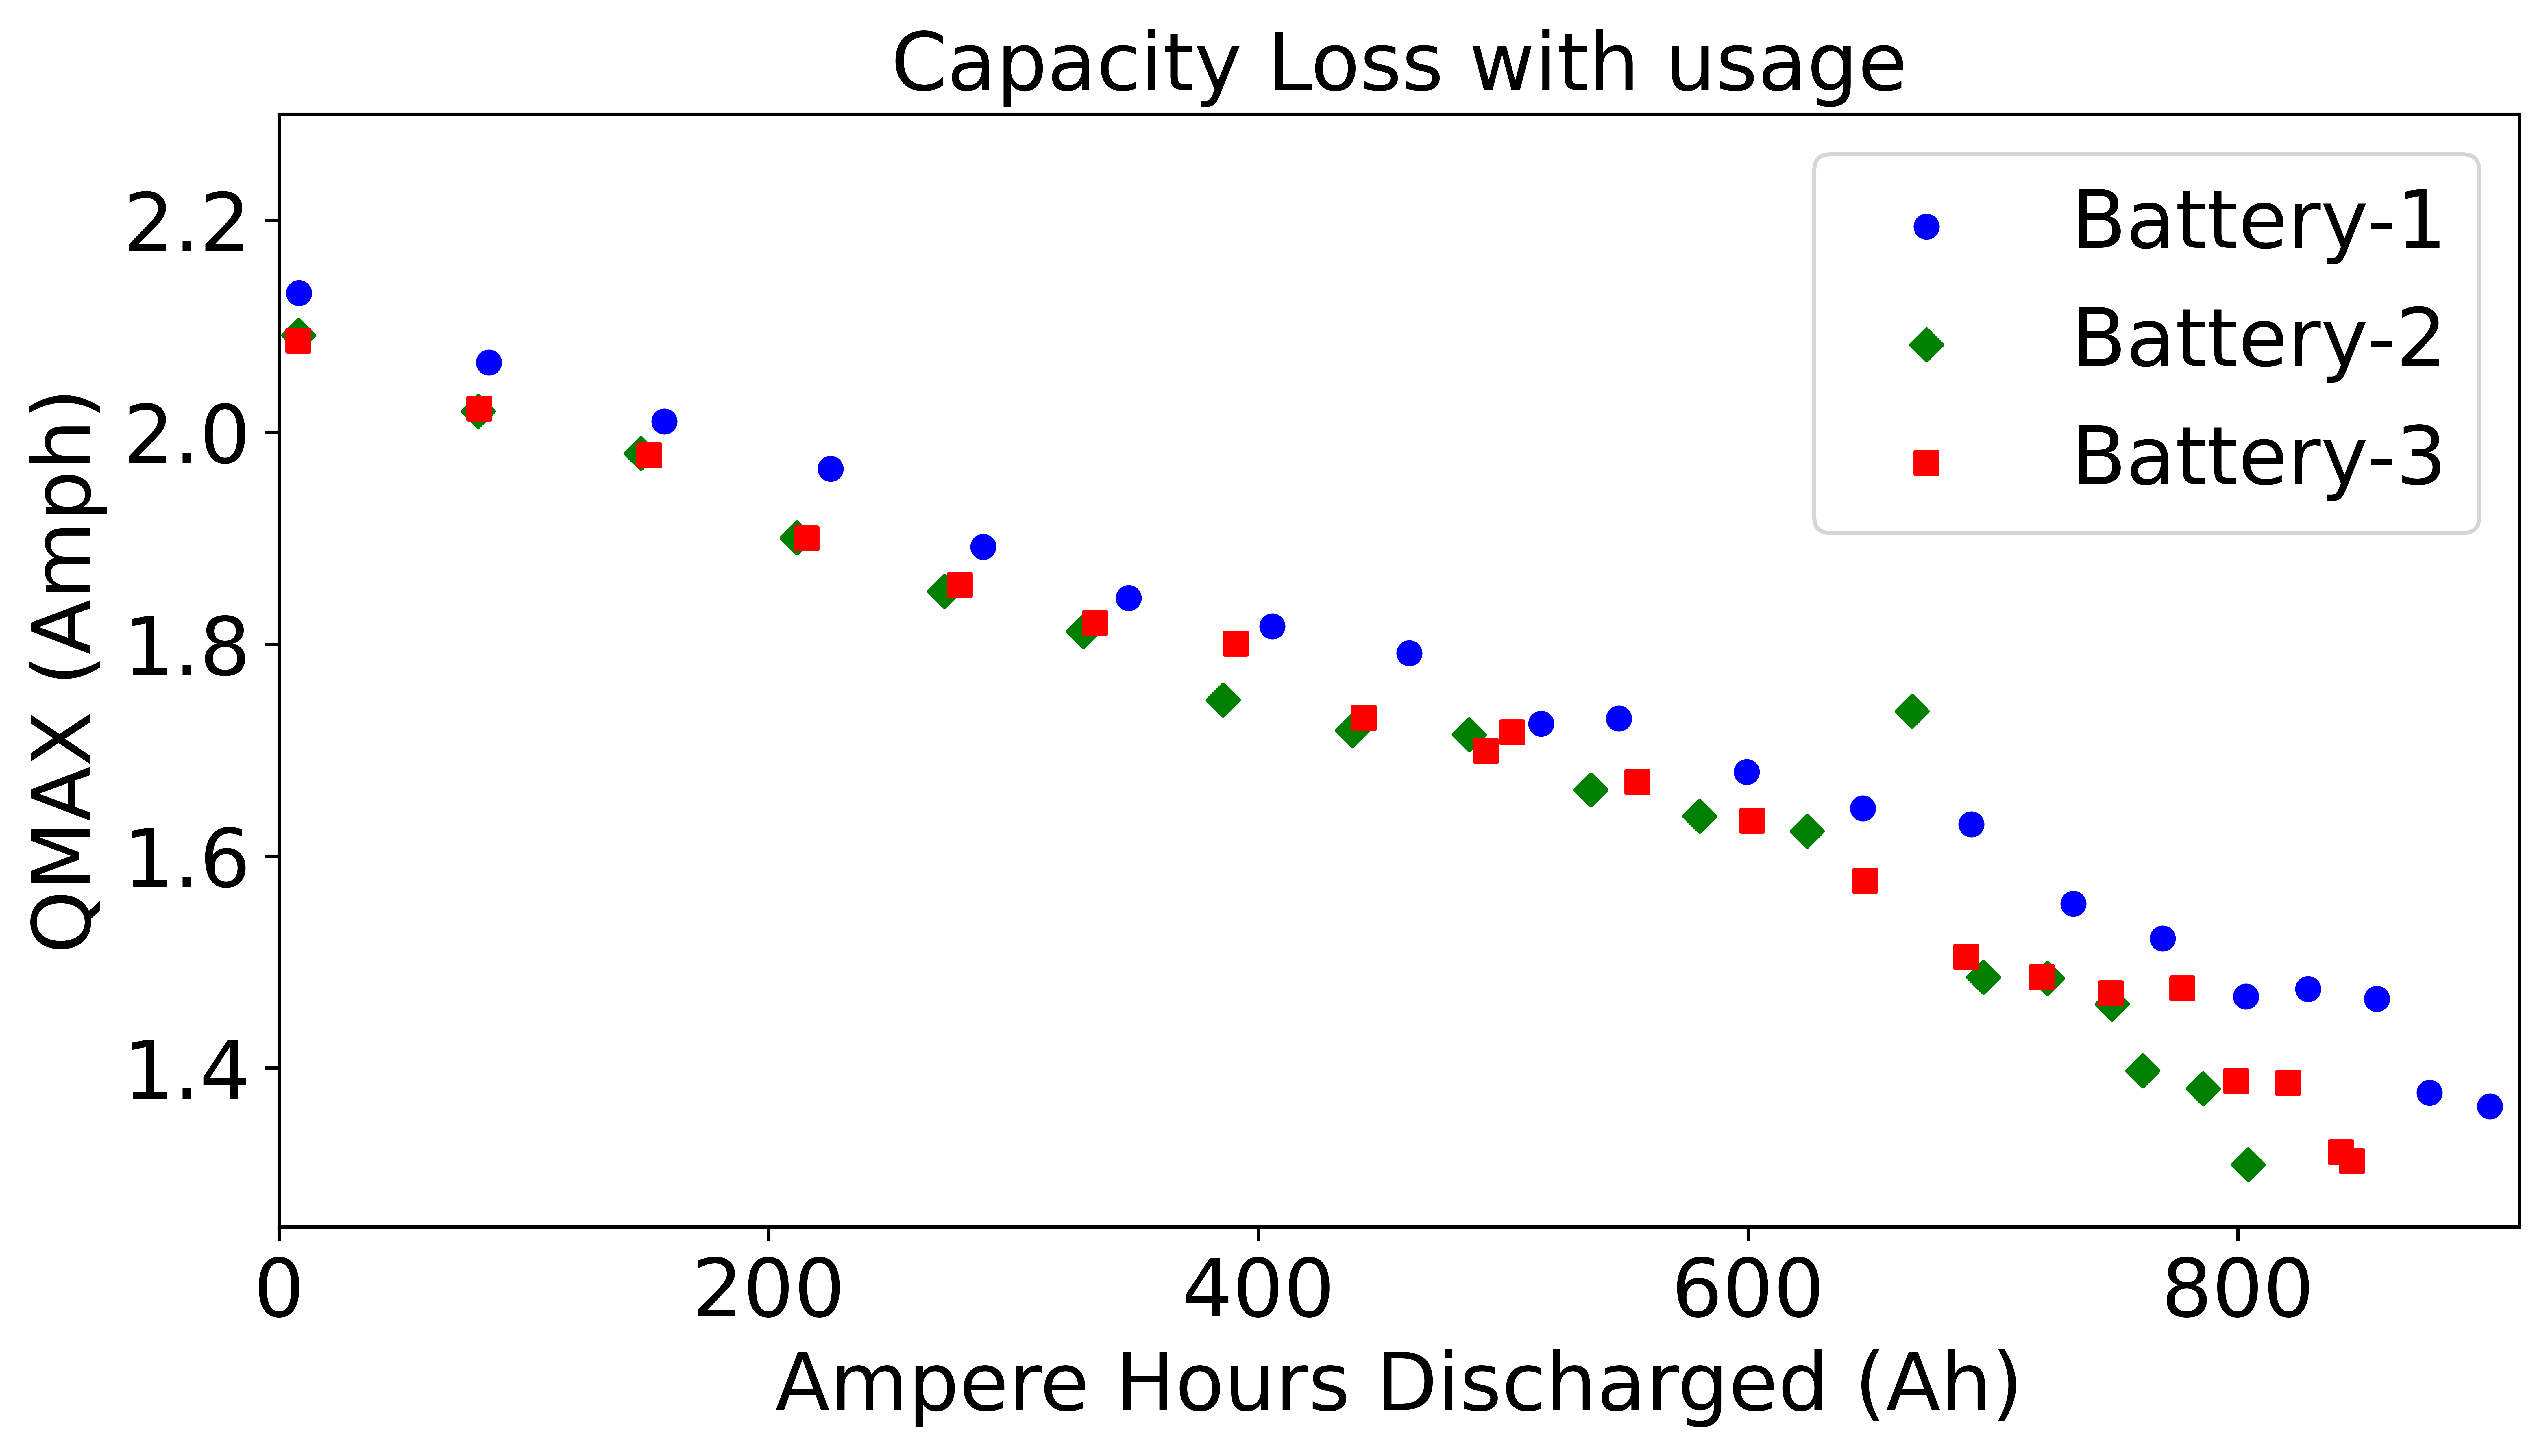

In [7]:
#Plotting Similar dimensions wrt the publication
plt.figure(figsize=(10, 5)) # Setting 1:2 dimensions
#last two values are not considered for battery-1
plt.scatter(Amph1[:-2],(0.6*Qrun1[:-2])/3600,label='Battery-1',s=30, marker = "o", color = "blue") # B-1 -> Capacity vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph1[:-2],(0.6*Qrun1[:-2])/3600,linewidth=0.75, color = "blue")
plt.scatter(Amph2,(0.6*Qrun2)/3600,label='Battery-2',s=30, marker = "D" , color = "green") # B-2 -> Capacity vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph2,(0.6*Qrun2)/3600,linewidth=0.75, color = "green")
plt.scatter(Amph3,(0.6*Qrun3)/3600,label='Battery-3',s=30, marker = "s" , color = "red") # B-3 -> Capacity vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph3,(0.6*Qrun3)/3600,linewidth=0.75, color = "red")
plt.ylabel('QMAX (Amph)', fontsize=20)
plt.xlabel('Ampere Hours Discharged (Ah)', fontsize=20)
plt.title('Capacity Loss with usage', fontsize=20)
plt.legend(loc="upper right", prop={'size': 20})
# Setting limits wrt paper
plt.ylim([1.25,2.3])
plt.xlim([0, 915])
# Setting ticks wrt paper
plt.yticks([1.4,1.6,1.8,2,2.2],size = 20)
plt.xticks(size = 20)
plt.show()

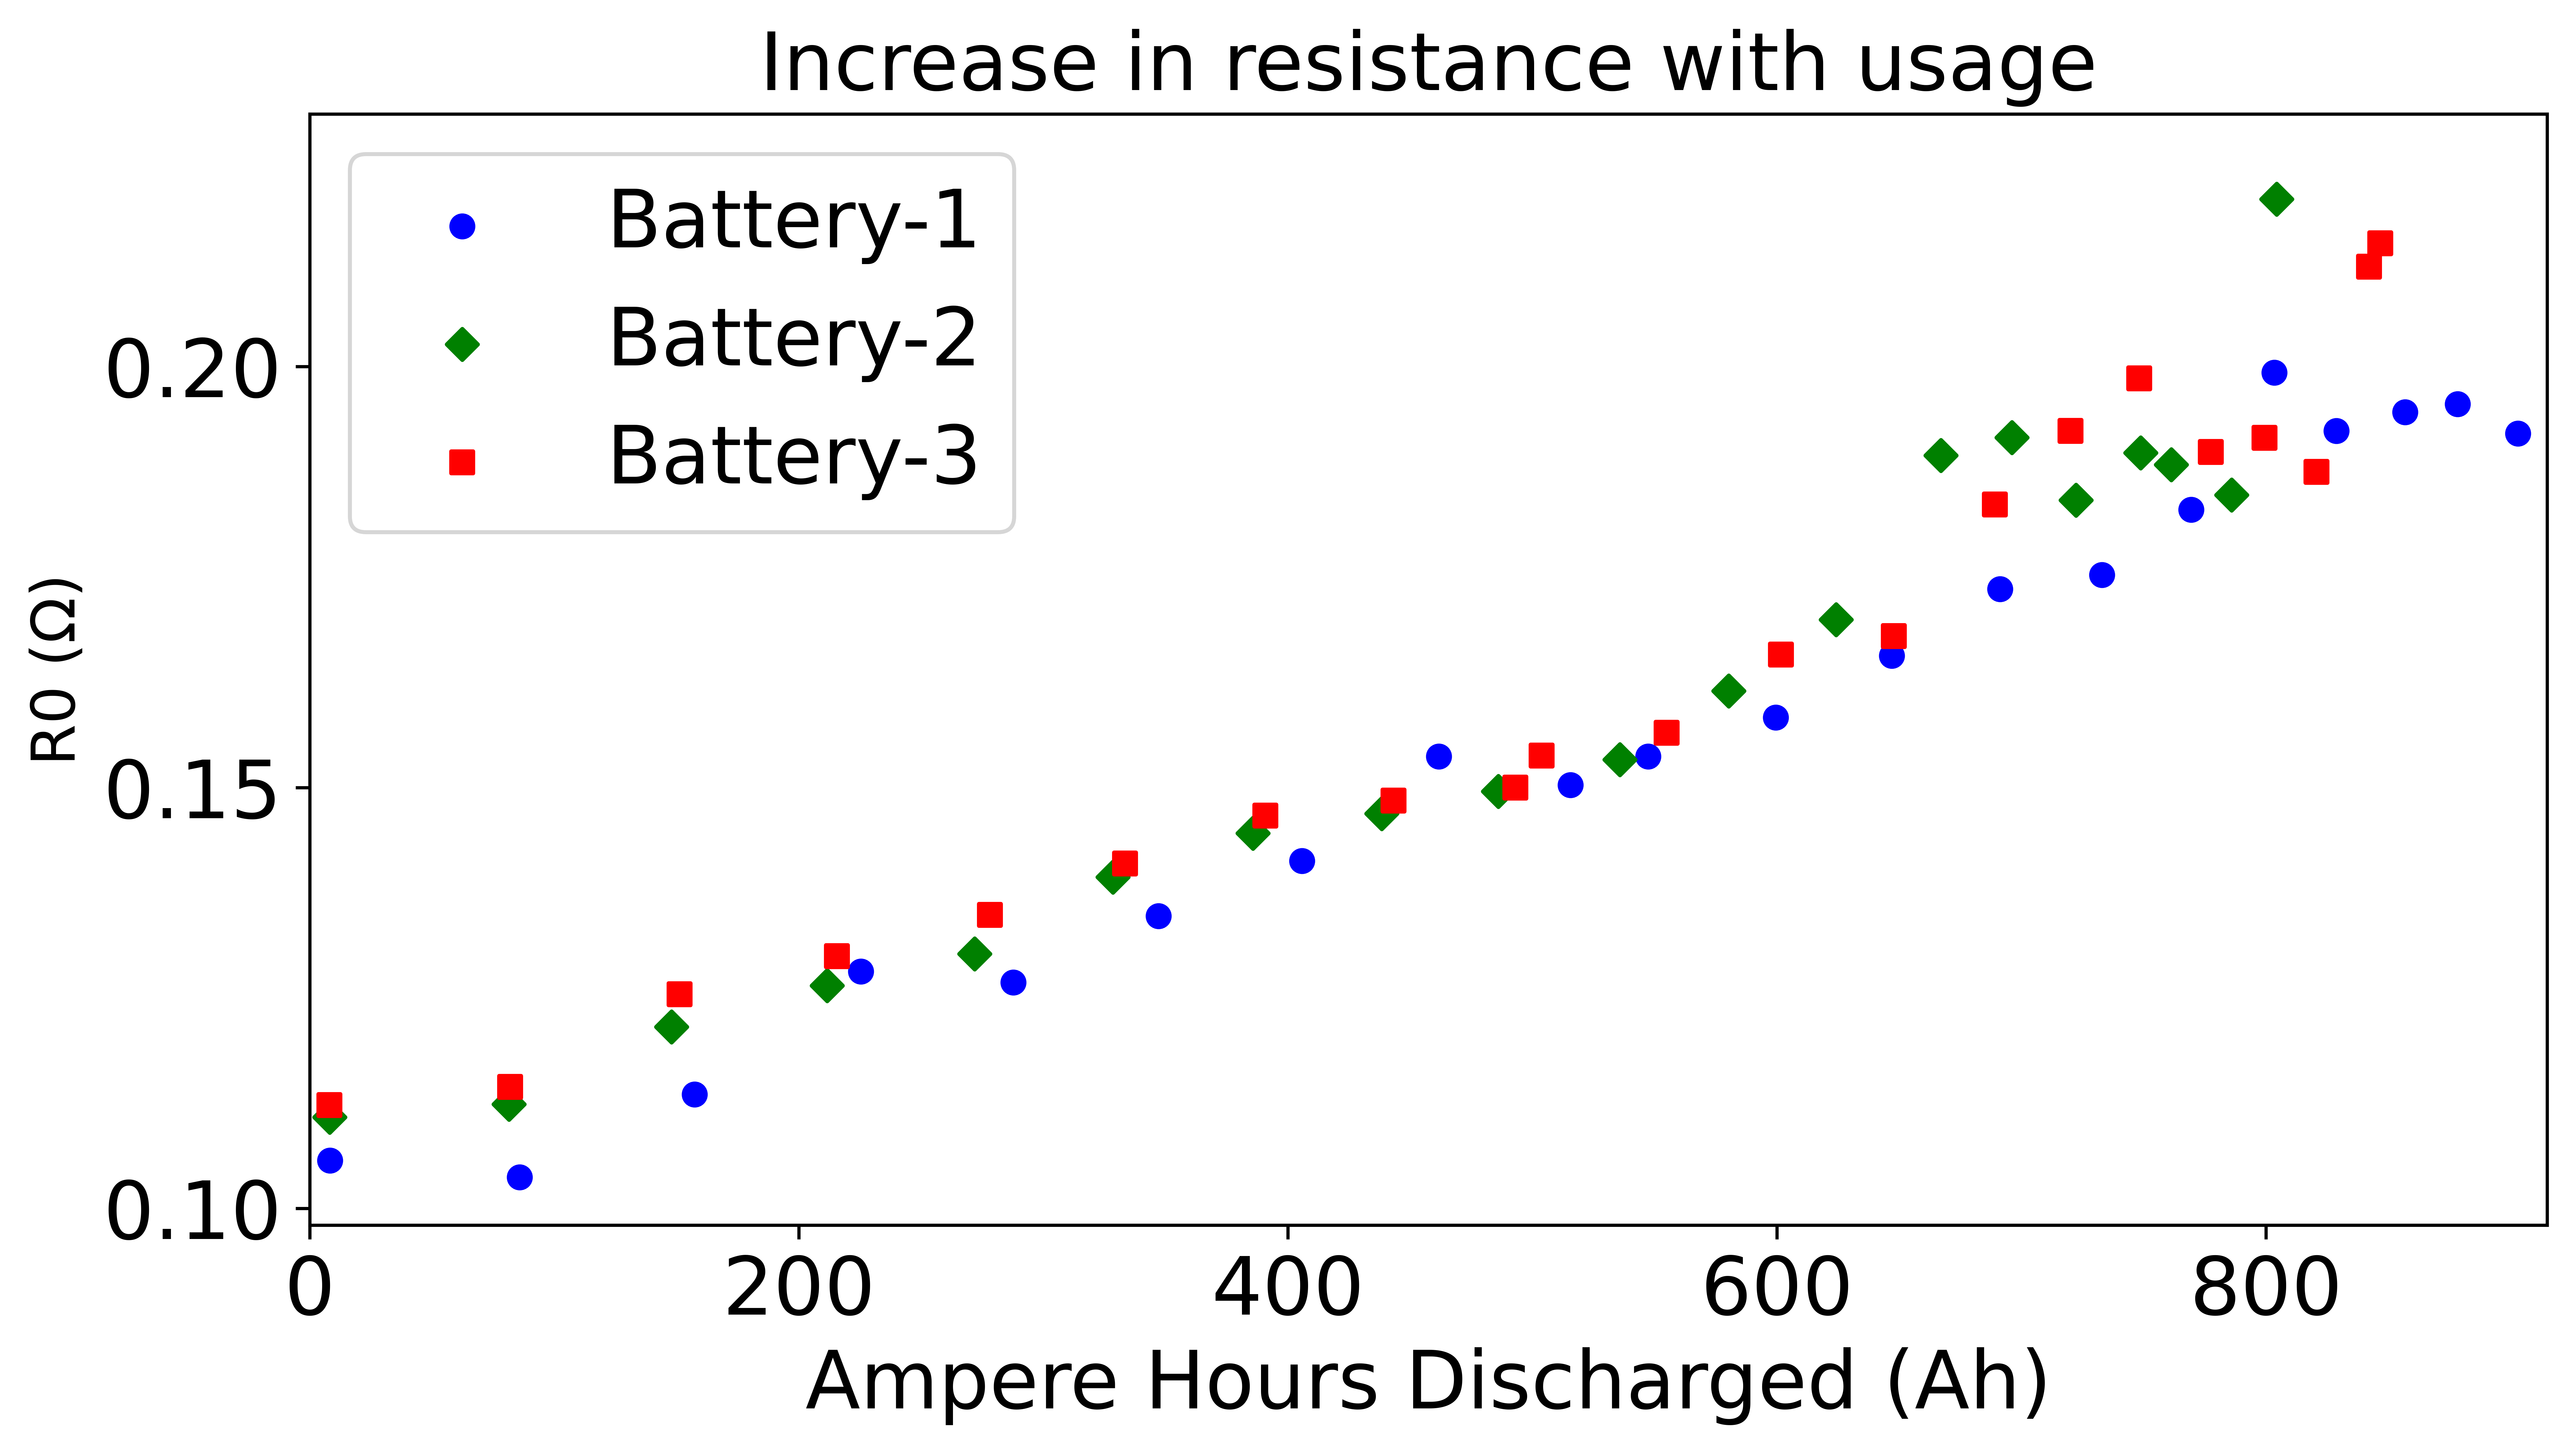

In [8]:
#Plotting Similar dimensions wrt the publication
plt.figure(figsize=(10, 5)) # Setting 1:2 dimensions
#last two values are not considered for battery-1
plt.scatter(Amph1[:-2],R0run1[:-2],label='Battery-1',s=30, marker = "o", color = "blue") # B-1 -> Resistance vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph1[:-2],R0run1[:-2],linewidth=0.75,color = "blue")
plt.scatter(Amph2,R0run2,label='Battery-2',s=30, marker = "D" , color = "green") # B-2 -> Resistance vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph2,R0run2,linewidth=0.75, color = "green")
plt.scatter(Amph3,R0run3,label='Battery-3',s=30, marker = "s" , color = "red") # B-3 -> Resistance vs Amph Discharged (from the start of the experiment)
#plt.plot(Amph3,R0run3,linewidth=0.75, color = "red")
plt.ylabel('R0 (\u03A9)',fontsize=15)
plt.xlabel('Ampere Hours Discharged (Ah)',fontsize=20)
plt.title('Increase in resistance with usage',size=20)
plt.legend(loc="upper left", prop={'size': 20})
# Setting limits wrt paper
plt.ylim([0.098,0.23])
plt.xlim([0, 915])
# Setting ticks wrt paper
plt.yticks([0.1,0.15,0.2],size=20)
plt.xticks(size=20)
plt.show()

Regression:

In [9]:
#Section 5.4 - Regression Fit of Capacity wrt Amperes Hour Discharged
from sklearn.linear_model import LinearRegression
X1 = (np.array(Amph1[:-2])).reshape(-1, 1)
y1 = (np.array(Qrun1[:-2]*0.6)).reshape(-1, 1) 
reg1 = LinearRegression().fit(X1, y1)
# Reference - Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use
# Table 1, pg5
print(reg1.score(X1, y1)) # R2 score (To compare with paper)
print(reg1.coef_/3600) # Coefficient attached to Amph variable (To compare with paper)
print(reg1.intercept_/3600) # y-axis Intercept value (To compare with paper)
#reg1.predict() #For predicting Capacity at different ampere hour discharged values

0.9883705343808844
[[-0.00081717]]
[2.14674659]


In [10]:
#Section 5.4 - Regression Fit of Internal Resistance wrt Amperes Hour Discharged
from sklearn.linear_model import LinearRegression
X2 = (np.array(Amph1[:-2])).reshape(-1, 1)
y2 = (np.array(R0run1[:-2])).reshape(-1, 1)
reg2 = LinearRegression().fit(X2, y2)
# Reference - Adaptation of an Electrochemistry-based Li-Ion Battery Model to Account for Deterioration Observed Under Randomized Use
# Table 1, pg5
print(reg2.score(X2, y2)) # R2 score (To compare with paper)
print(reg2.coef_) # Coefficient attached to Amph variable (To compare with paper)
print(reg2.intercept_) # y-axis Intercept value (To compare with paper)
#reg2.predict() [For predicting Internal Resistance at different amepere hour discharged values]

0.9765029563291169
[[0.00011004]]
[0.09790525]


In [11]:
#Section 5.4 - Regression Fit of Measured Capacity wrt Amperes Hour Discharged
from sklearn.linear_model import LinearRegression
X3 = (np.array(Amph1[:-2])).reshape(-1, 1)
y3 = (np.array(Measured_Capacity1[:-2])).reshape(-1, 1)
reg3 = LinearRegression().fit(X3, y3)
print(reg3.score(X3, y3)) # R2 score (To compare with paper)
print(reg3.coef_) # Coefficient attached to Amph variable (To compare with paper)
print(reg3.intercept_) # y-axis Intercept value (To compare with paper)
#reg3.predict() [For predicting Measured Capacity at different amepere hour discharged values]

0.9880146322612625
[[-2.86516231]]
[7372.83662026]


In [12]:
#Forming the Fitted Straight line for visualization
Fitted_x = np.zeros(908)
Fitted_y1 = np.zeros(908)
Fitted_y2 = np.zeros(908)
Fitted_y3 = np.zeros(908)
for i in range (908):
    Fitted_x[i] = i+3
    # Using coefficients and y-intercept with constantly increasing (1 unit) x values (Amph)
    Fitted_y1[i] = Fitted_x[i]*(reg1.coef_[0][0]) + reg1.intercept_[0] 
    Fitted_y2[i] = Fitted_x[i]*(reg2.coef_[0][0]) + reg2.intercept_[0]
    Fitted_y3[i] = Fitted_x[i]*(reg3.coef_[0][0]) + reg3.intercept_[0]

Regression Plots:

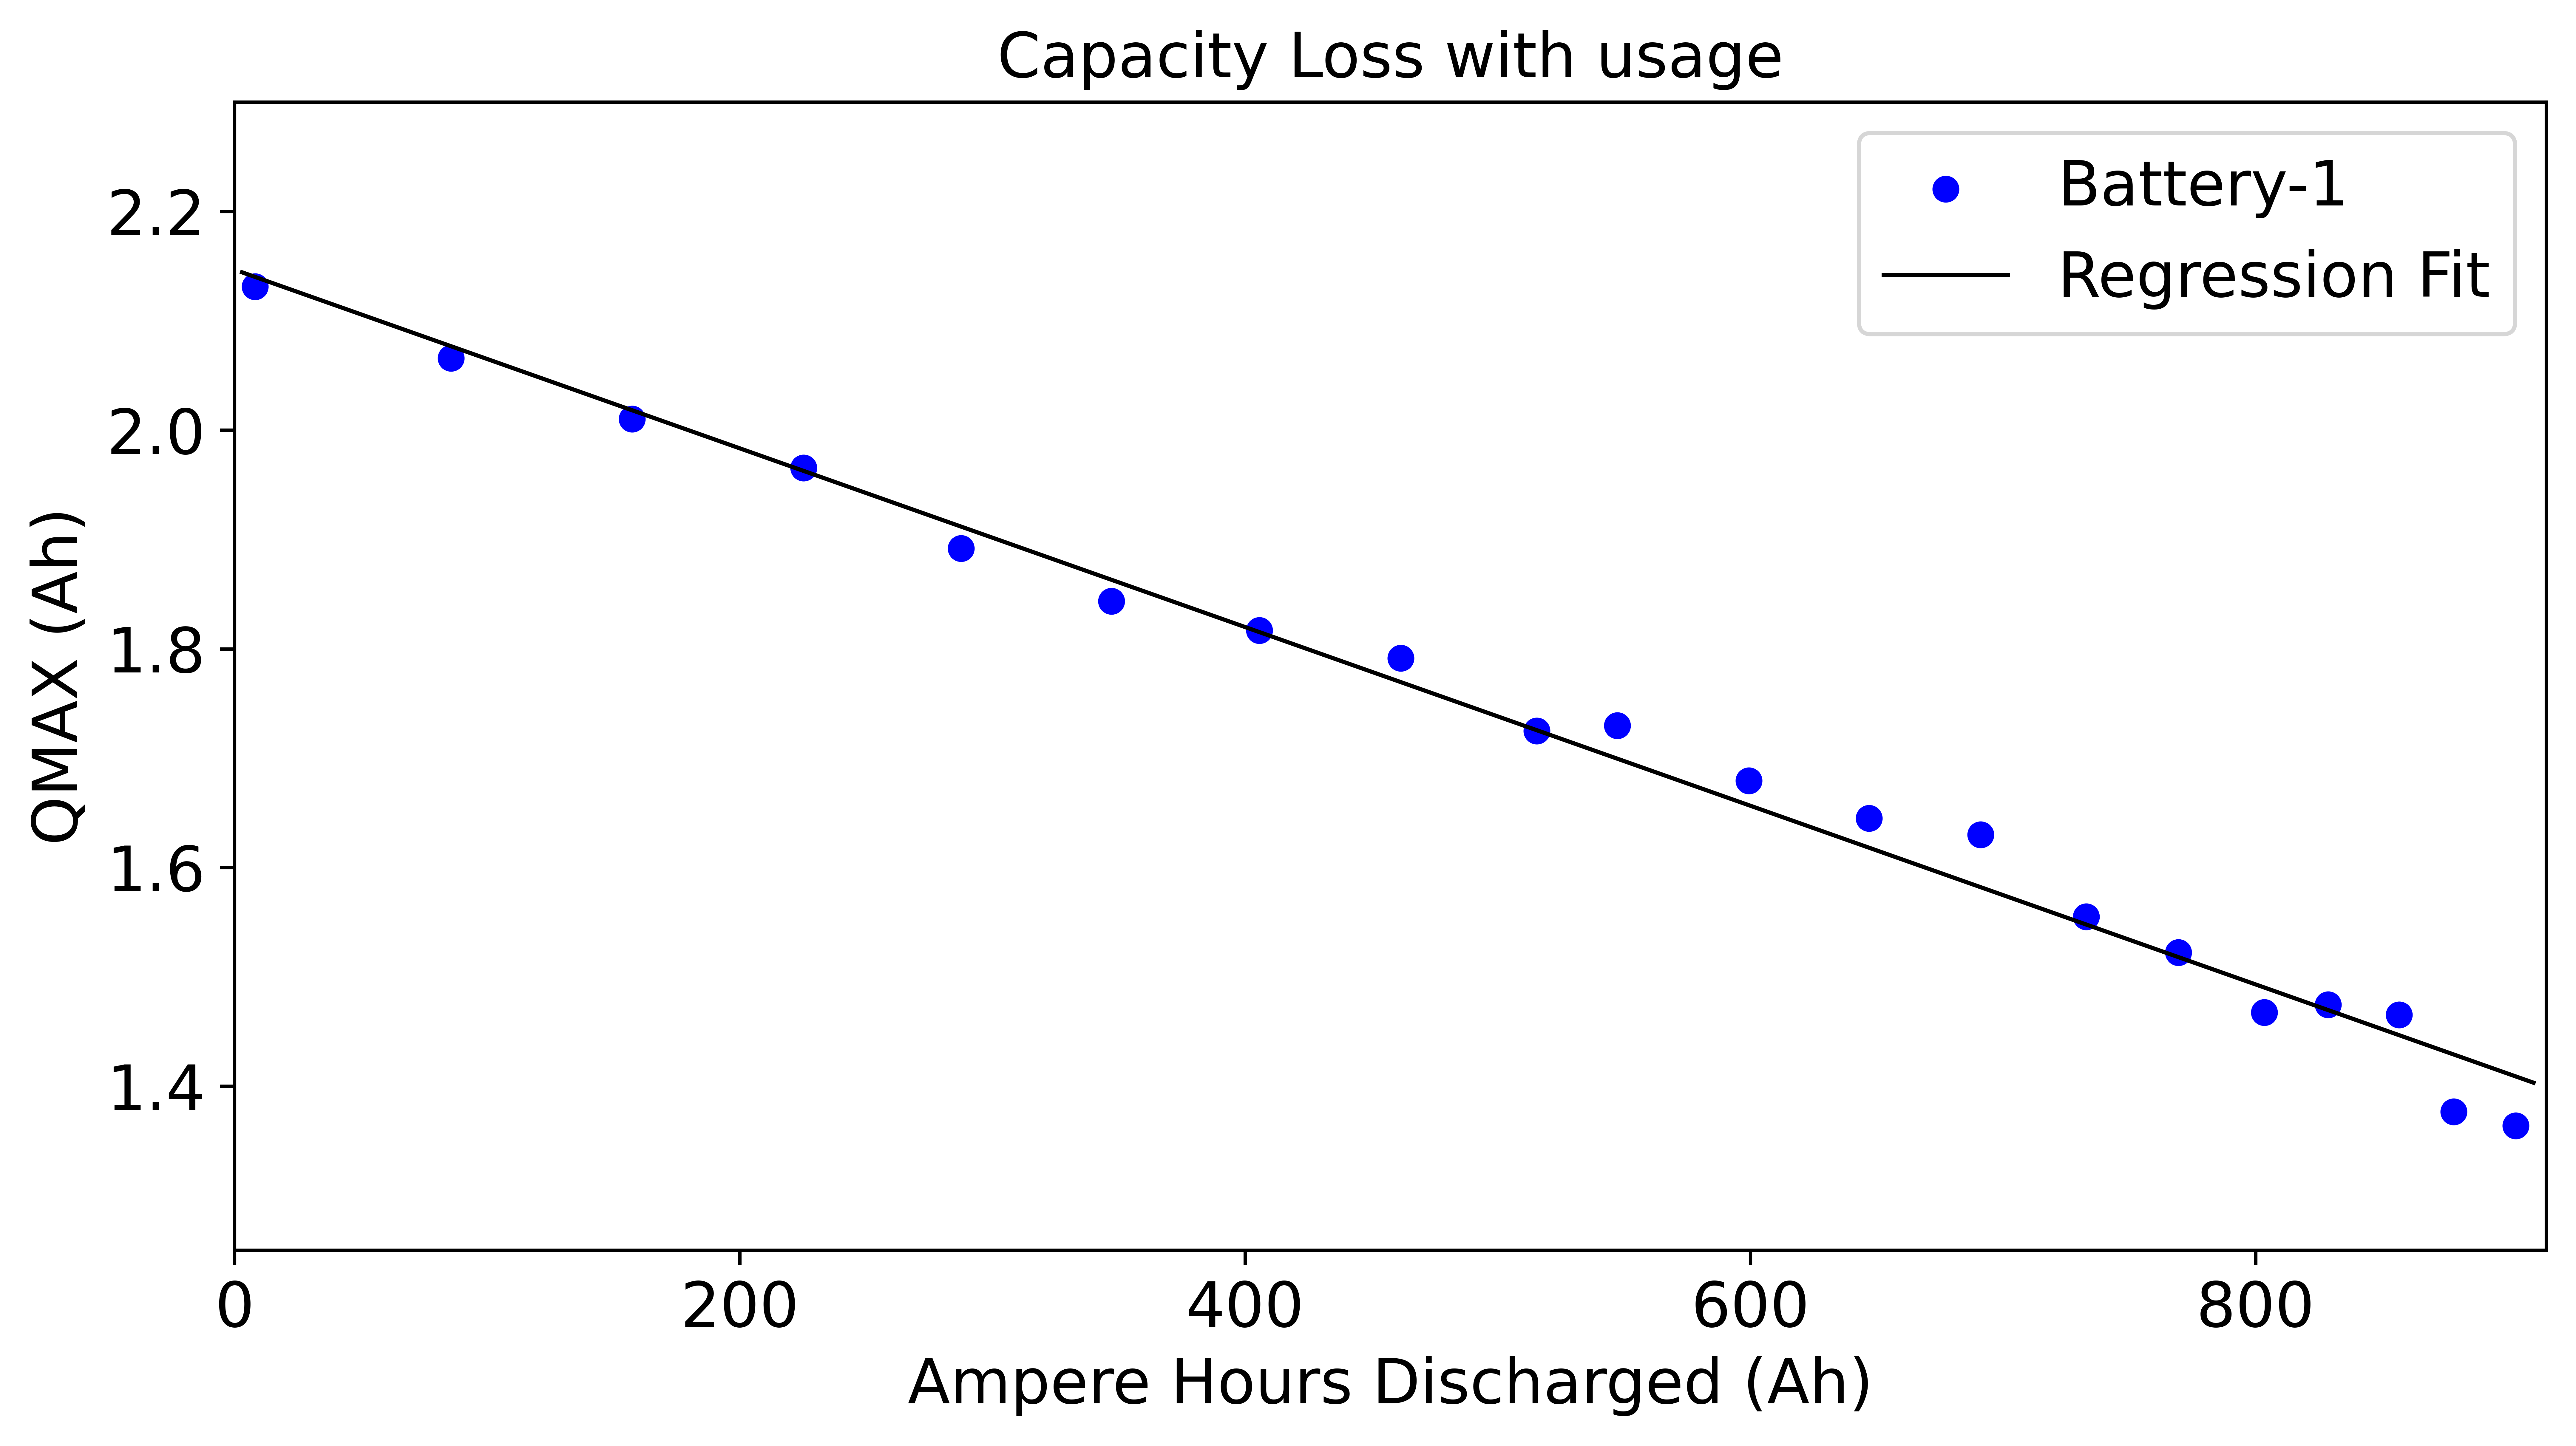

In [13]:
#Capacity Fade Plot
plt.figure(figsize=(10, 5)) # Setting 1:2 dimensions
plt.scatter(Amph1[:-2],(0.6*Qrun1[:-2])/3600,label='Battery-1',s=30, marker = "o", color = "blue") # Original Capacity values of battery-1 (wrt Ampere hours discharged)
plt.plot(Fitted_x,Fitted_y1/3600,label = "Regression Fit",linewidth=1,color = "black") # Regression Fitted Line for the Capacity values of battery-1 (wrt Ampere hours discharged)
plt.ylabel('QMAX (Ah)',size=15)
plt.xlabel('Ampere Hours Discharged (Ah)',size=15)
plt.title('Capacity Loss with usage',size=15)
plt.legend(loc="upper right", prop={'size': 15})
# Setting limits wrt paper
plt.ylim([1.25,2.3])
plt.xlim([0, 915])
# Setting ticks wrt paper
plt.yticks([1.4,1.6,1.8,2,2.2],size=15)
plt.xticks(size=15)
plt.show()

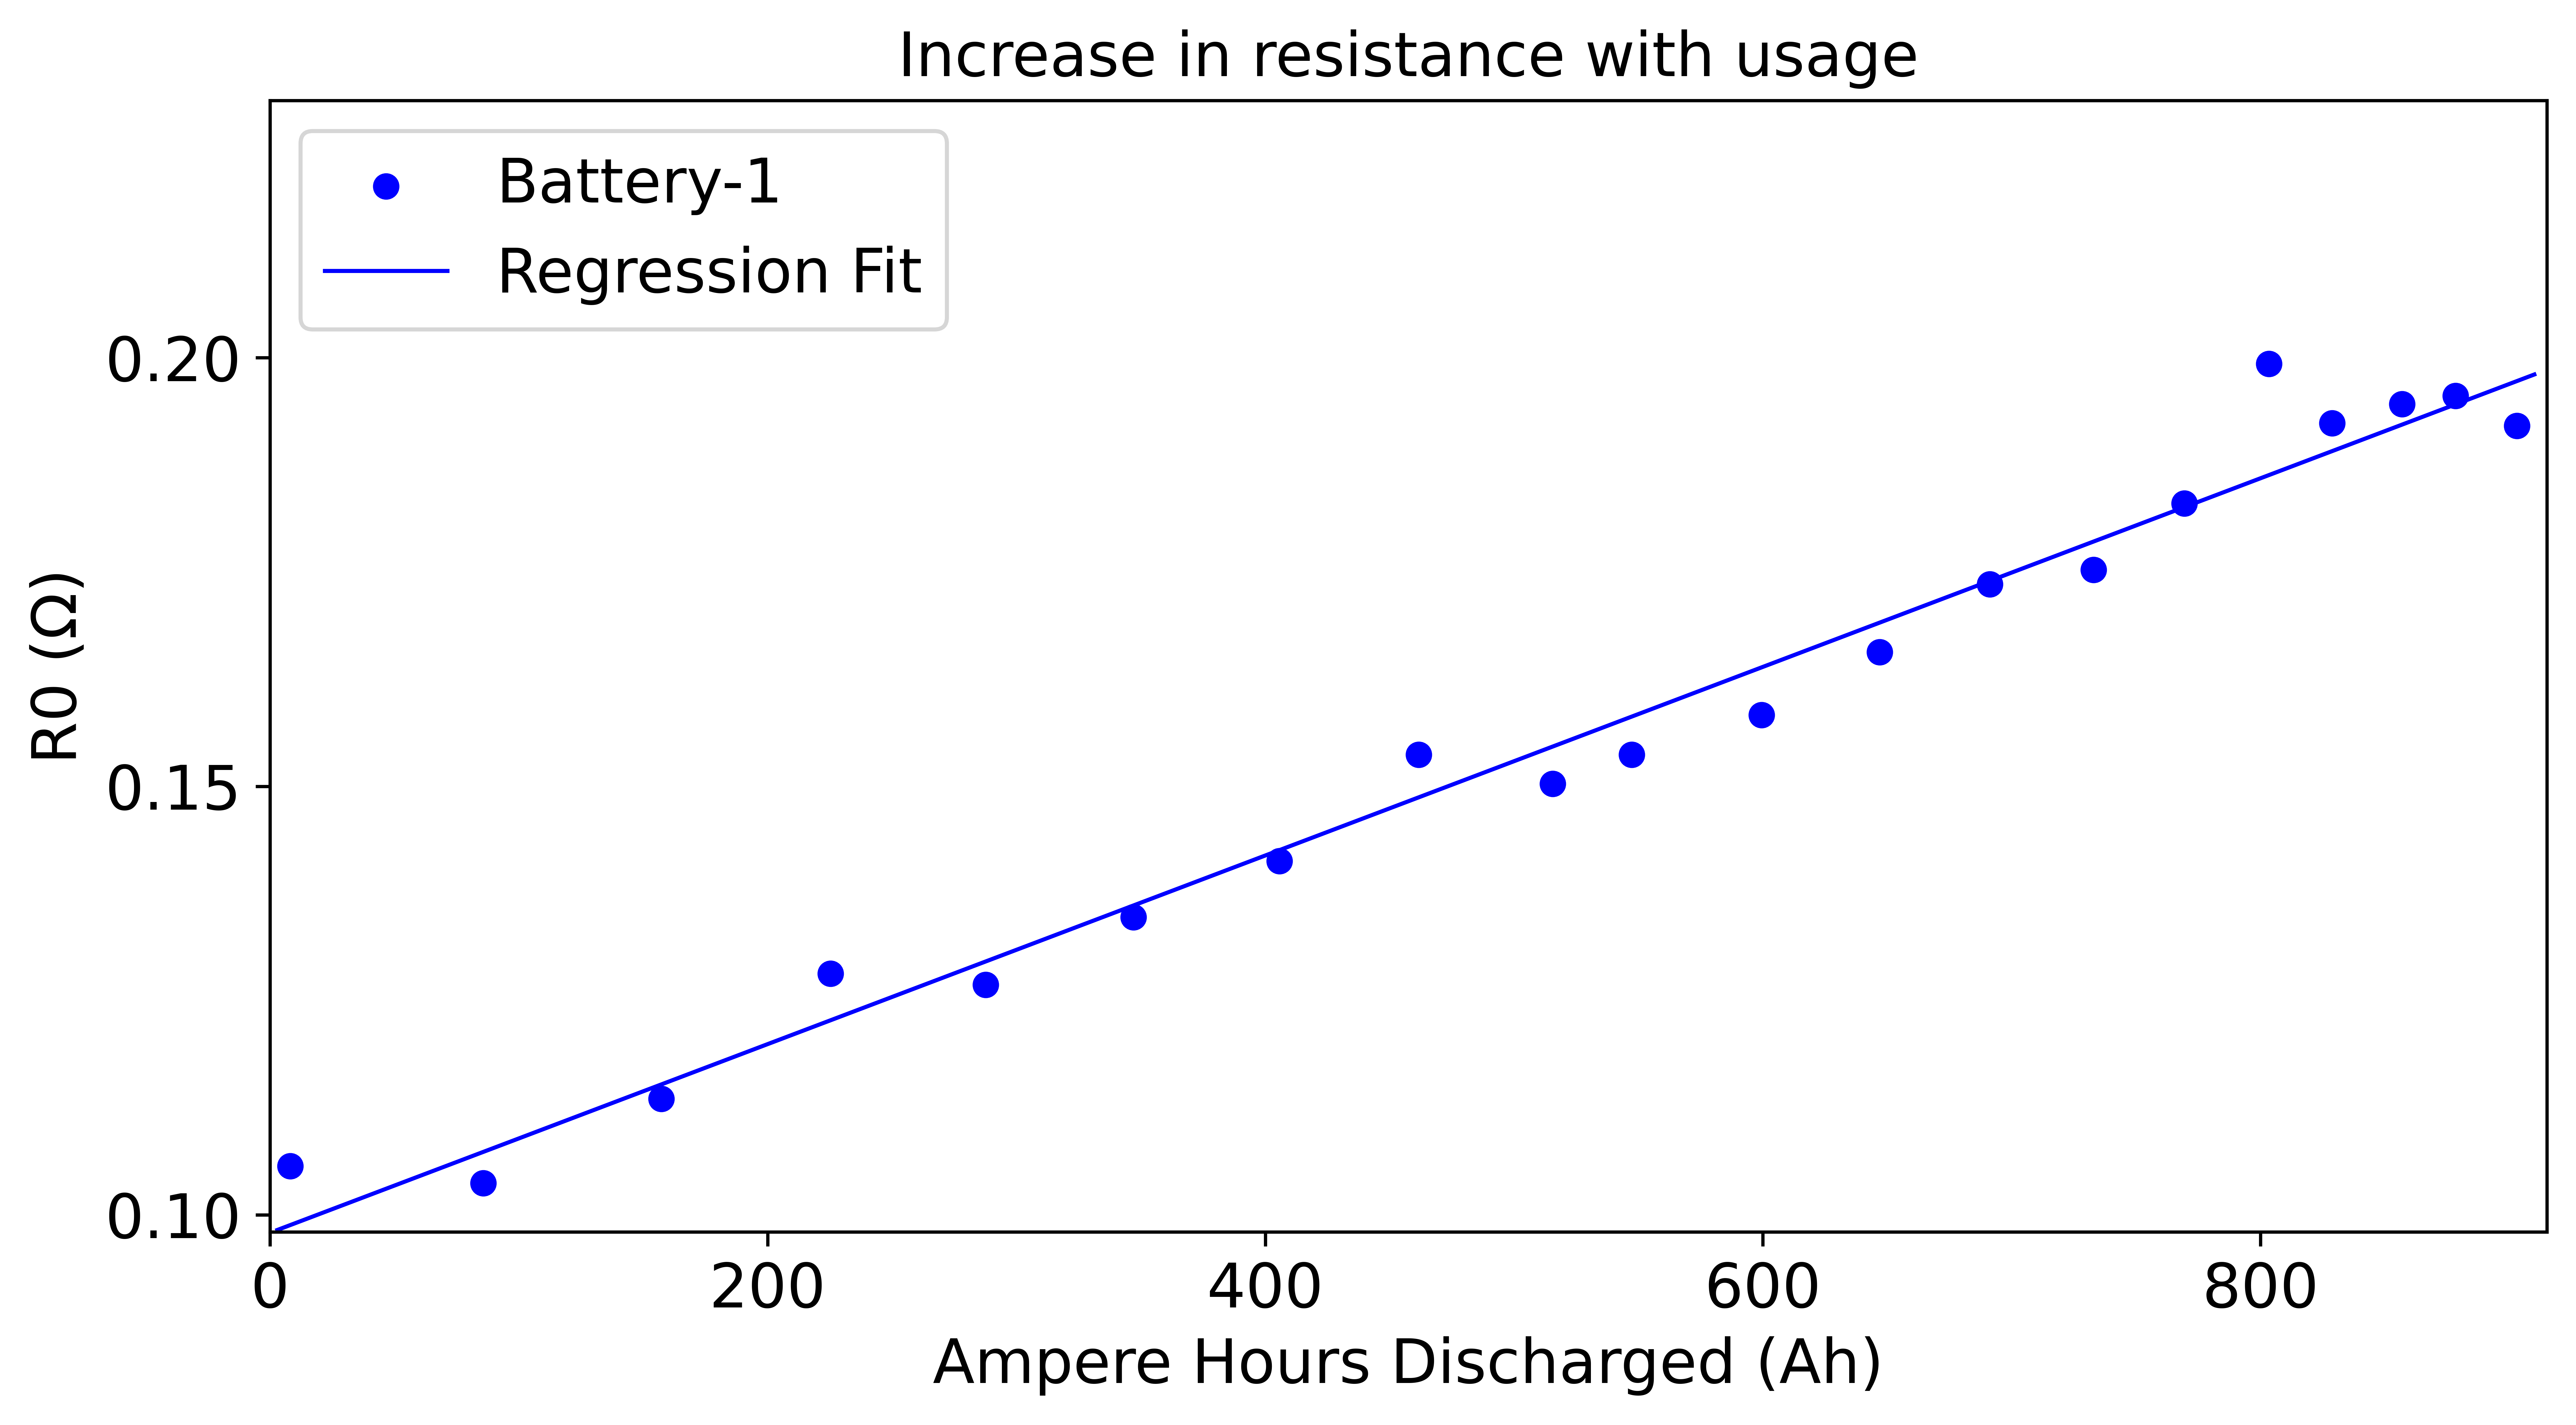

In [14]:
#Increasing Resistance Plot
plt.figure(figsize=(10, 5)) # Setting 1:2 dimensions
plt.scatter(Amph1[:-2],R0run1[:-2],label='Battery-1',s=30, marker = "o", color = "blue") # Original Internal Resistance values of battery-1 (wrt Ampere hours discharged)
plt.plot(Fitted_x,Fitted_y2,label = "Regression Fit",linewidth=1,color = "blue") # Regression Fitted Line for the Internal Resistance values of battery-1 (wrt Ampere hours discharged)
plt.ylabel('R0 (\u03A9)',size=15)
plt.xlabel('Ampere Hours Discharged (Ah)',size=15)
plt.title('Increase in resistance with usage',size=15)
plt.legend(loc="upper left", prop={'size': 15})
# Setting limits wrt paper
plt.ylim([0.098,0.23])
plt.xlim([0, 915])
# Setting ticks wrt paper
plt.yticks([0.1,0.15,0.2],size=15)
plt.xticks(size=15)
plt.show()

In [15]:
'''Measured Capacity Plot (Extra/Personal Exploration)
plt.figure()
plt.scatter(Amph1,Measured_Capacity1/3600,label='Battery-1',s=5)
plt.plot(Fitted_x,Fitted_y3/3600,label = "Regression Fit",linewidth=0.75)
plt.ylabel('Measured Capacity (Ah)')
plt.xlabel('Ampere Hours Discharged (Ah)')
plt.title('Measured Capacity Loss with usage')
plt.legend(loc="upper right", prop={'size': 6})
plt.show()'''

'Measured Capacity Plot (Extra/Personal Exploration)\nplt.figure()\nplt.scatter(Amph1,Measured_Capacity1/3600,label=\'Battery-1\',s=5)\nplt.plot(Fitted_x,Fitted_y3/3600,label = "Regression Fit",linewidth=0.75)\nplt.ylabel(\'Measured Capacity (Ah)\')\nplt.xlabel(\'Ampere Hours Discharged (Ah)\')\nplt.title(\'Measured Capacity Loss with usage\')\nplt.legend(loc="upper right", prop={\'size\': 6})\nplt.show()'